### Machine Learning + Deep Learning

In [1]:
#pip install tensorflow

In [180]:
#Imports
import pandas as pd
import psycopg2
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pickle

from sqlalchemy import create_engine, Column, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score ,learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

from collections import Counter

In [181]:
#print(tf.sysconfig.get_build_info().keys())
#print(tf.version.VERSION)


In [182]:
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group23',
    'password': 'blockd_2024group23_14'
}

In [183]:
# Connect to the PostgreSQL database
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

In [184]:
query = "SELECT * FROM group23_warehouse.joined_table_final;"
cursor.execute(query)
rows = cursor.fetchall()

print("Column Names:")
columns = [desc[0] for desc in cursor.description]
for column in columns:
    print(column)

df = pd.DataFrame(rows, columns=columns)

Column Names:
Road condition
Road surface
street
weather
event_start
event_end
duration_seconds
speed_kmh
end_speed_kmh
maxwaarde
category
incident_severity
place_name
is_valid
latitude
longitude
precipitation_secs


In [185]:
print(df.head())

  Road condition     Road surface        street weather  \
0       Wet/damp  Asphalt (other)      Elleboog    Rain   
1       Wet/damp  Asphalt (other)   Lunetstraat     Dry   
2       Wet/damp  Asphalt (other)  Emerparklaan    Rain   
3       Wet/damp  Asphalt (other)  Emerparklaan    Rain   
4       Wet/damp  Asphalt (other)  Emerparklaan    Rain   

              event_start               event_end  duration_seconds  \
0 2018-01-27 18:30:11.400 2018-01-27 18:30:13.300               1.9   
1 2018-01-27 09:24:21.600 2018-01-27 09:24:22.900               1.3   
2 2018-01-27 14:04:40.500 2018-01-27 14:04:52.500              12.0   
3 2018-01-27 14:04:40.500 2018-01-27 14:04:52.500              12.0   
4 2018-01-27 14:04:40.500 2018-01-27 14:04:52.500              12.0   

   speed_kmh  end_speed_kmh  maxwaarde          category incident_severity  \
0  33.796223      22.530815   0.954341  HARSH CORNERING              HC1     
1  20.921473      22.530815   0.703283  HARSH CORNERING       

In [186]:
display(df.head())

,Road condition,Road surface,street,weather,event_start,event_end,duration_seconds,speed_kmh,end_speed_kmh,maxwaarde,category,incident_severity,place_name,is_valid,latitude,longitude,precipitation_secs
0,Wet/damp,Asphalt (other),Elleboog,Rain,2018-01-27 18:30:11.400,2018-01-27 18:30:13.300,1.9,33.796223,22.530815,0.954341,HARSH CORNERING,HC1,Breda,True,51.60394,4.723639,110.333333
1,Wet/damp,Asphalt (other),Lunetstraat,Dry,2018-01-27 09:24:21.600,2018-01-27 09:24:22.900,1.3,20.921473,22.530815,0.703283,HARSH CORNERING,HC1,Breda,True,51.59621,4.750157,110.333333
2,Wet/damp,Asphalt (other),Emerparklaan,Rain,2018-01-27 14:04:40.500,2018-01-27 14:04:52.500,12.0,62.764416,62.764416,64.373760,SPEED,SP1,Breda,True,51.60857,4.752278,110.333333
3,Wet/damp,Asphalt (other),Emerparklaan,Rain,2018-01-27 14:04:40.500,2018-01-27 14:04:52.500,12.0,62.764416,62.764416,64.373760,SPEED,SP1,Breda,True,51.60857,4.752278,110.333333
4,Wet/damp,Asphalt (other),Emerparklaan,Rain,2018-01-27 14:04:40.500,2018-01-27 14:04:52.500,12.0,62.764416,62.764416,64.373760,SPEED,SP1,Breda,True,51.60857,4.752278,110.333333


## EDA for the joined table

In [187]:
# Dropping the duplicate rows 
df = df.drop_duplicates()

['HARSH CORNERING' 'SPEED' 'BRAKING' 'ACCELERATING']
<class 'pandas.core.frame.DataFrame'>
Index: 1117186 entries, 0 to 2295500
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   Road condition      1117186 non-null  object        
 1   Road surface        1117186 non-null  object        
 2   street              1117186 non-null  object        
 3   weather             1117186 non-null  object        
 4   event_start         1117186 non-null  datetime64[ns]
 5   event_end           1117186 non-null  datetime64[ns]
 6   duration_seconds    1117186 non-null  float64       
 7   speed_kmh           1117186 non-null  float64       
 8   end_speed_kmh       1117186 non-null  float64       
 9   maxwaarde           1117186 non-null  float64       
 10  category            1117186 non-null  object        
 11  incident_severity   1117186 non-null  object        
 12  place_name          11

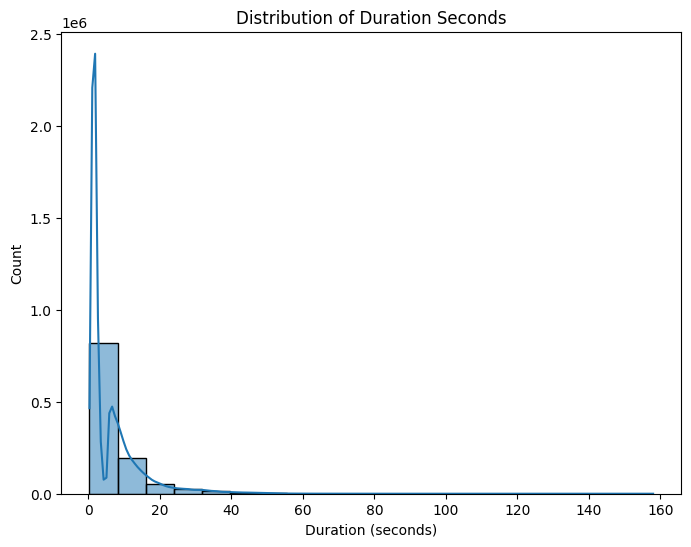

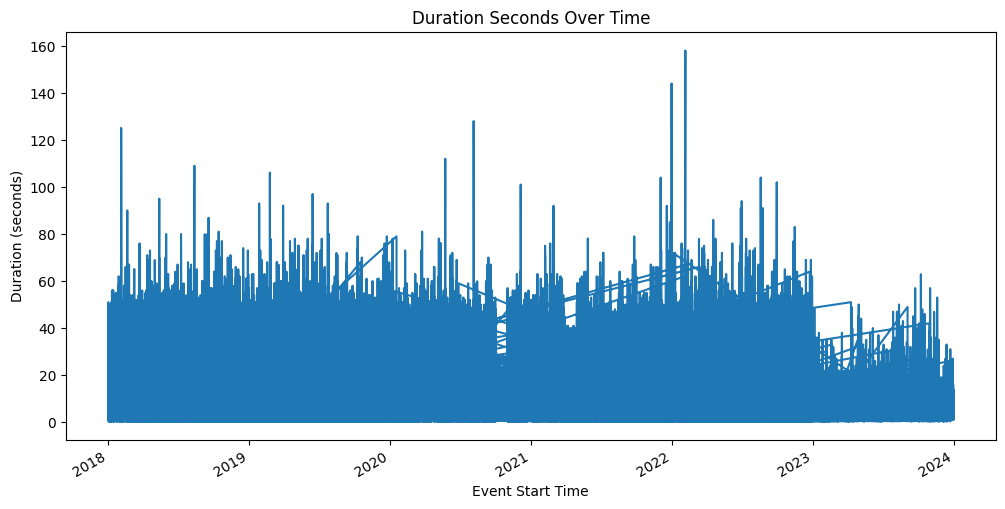

In [188]:
# This code removes whitespaces from the category column because we had two of each was not right
df['category'] = df['category'].str.strip()

# I'm merging the categories together based on the name
df['category'] = df['category'].replace({
    'HARSH CORNERING': 'HARSH CORNERING',
    'HARSH CORNERING ': 'HARSH CORNERING',
})

# Checking the unique values , data structure , summary and missing values , value counts for categories and incident_severity
print(df['category'].unique())
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df['category'].value_counts())
print(df['incident_severity'].value_counts())

# Visualizations to check how the data looks like 
# Histogram of duration_seconds
plt.figure(figsize=(8, 6))
sns.histplot(df['duration_seconds'], bins=20, kde=True)
plt.title('Distribution of Duration Seconds')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

# Time series analysis - Duration seconds over event_start time
plt.figure(figsize=(12, 6))
df.set_index('event_start')['duration_seconds'].plot()
plt.title('Duration Seconds Over Time')
plt.xlabel('Event Start Time')
plt.ylabel('Duration (seconds)')
plt.show()

In [189]:
print(df)

        Road condition     Road surface                  street weather  \
0             Wet/damp  Asphalt (other)                Elleboog    Rain   
1             Wet/damp  Asphalt (other)             Lunetstraat     Dry   
2             Wet/damp  Asphalt (other)            Emerparklaan    Rain   
6             Wet/damp  Asphalt (other)            Emerparklaan     Dry   
7             Wet/damp  Asphalt (other)         Princenhagelaan     Dry   
...                ...              ...                     ...     ...   
2295494       Wet/damp   Porous asphalt  Franklin Rooseveltlaan    Rain   
2295496       Wet/damp            Brick  Franklin Rooseveltlaan     Dry   
2295497       Wet/damp   Porous asphalt  Franklin Rooseveltlaan    Rain   
2295499       Wet/damp            Brick  Franklin Rooseveltlaan     Dry   
2295500       Wet/damp  Asphalt (other)     Graaf Engelbertlaan     Dry   

                    event_start               event_end  duration_seconds  \
0       2018-01-27 18:

In [190]:
print(df['incident_severity'].value_counts())


incident_severity
HC1      340184
SP1      263839
HC1      251832
SP1      167992
HB1       24219
SP2       19779
SP2       15270
HB1       14211
HA1        3836
HC2        3379
HC2        2692
SP3        1939
HB2        1607
HA1        1601
SP3        1144
HB2         924
HC13        291
HA2         291
HC4         275
SP4         231
HC4         199
HC3         187
HA2         177
HC13        162
HC3         147
HB3         143
SP4          97
HC16         78
HC14         66
HC5          62
HB3          53
HC7          48
HA3          43
HC16         32
SP5          25
HC14         21
SP5          17
HC17         15
HC7          12
HC19         11
HC5          11
HC8           9
HA3           8
HC6           8
HC17          7
HC18          4
HC15          3
HC8           3
HC21          2
Name: count, dtype: int64


In [191]:
# df.to_csv('ML_DL_preprocessed.csv', index=False)

In [192]:
# To make sure that everything works I sampled the data first to 10%, 20%,30% and now I'm taking the full data set
sampled_data = df.sample(frac=0.1, random_state=42)

X = sampled_data[['Road condition', 'Road surface', 'street', 'weather' , 'maxwaarde']]
y = sampled_data['category']

# Split data into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [193]:
# Define preprocessing pipelines
numeric_features = ['maxwaarde']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_features = ['Road condition', 'Road surface', 'street']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### Balancing the category column

In [194]:
#pip install imblearn

In [195]:
#I chose to apply the SMOTE technique based on my research. The condocted research suggests that this technique has the best approach of oversampling the existing data in the target column,in our case 'category',
# for the tree-based algorithms that I am using later on , Random Forest and XGBoost. The research also showed that for the Deep learning part I should use a different technique to balance the data maybe by making
# use of class weights to address class imbalance during model training.

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, n_jobs = -1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Verify the class distribution after SMOTE
print("Class distribution for 'category' after SMOTE:")
print(y_train_resampled.value_counts())


/root/.cache/pypoetry/virtualenvs/2023-24d-fai1-adsai-teamwork-t23-W6229Z3H-py3.11/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Class distribution for 'category' after SMOTE:
category
HARSH CORNERING    42005
SPEED              42005
BRAKING            42005
ACCELERATING       42005
Name: count, dtype: int64


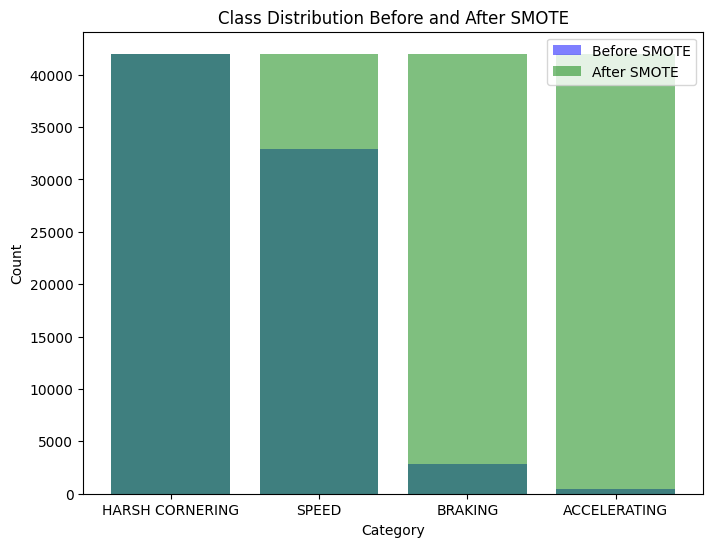

In [196]:
# Plot class distribution before SMOTE 
#plt.figure(figsize=(8, 6))
#plt.bar(y_train.value_counts().index, y_train.value_counts().values, color='blue', alpha=0.5, label='Before SMOTE')
#plt.bar(y_train_resampled.value_counts().index, y_train_resampled.value_counts().values, color='green', alpha=0.5, label='After SMOTE')
#plt.xlabel('Category')
#plt.ylabel('Count')
#plt.title('Class Distribution Before and After SMOTE')
#plt.legend()
#plt.show()

#Converting to pandas based on the error encountered "'numpy.ndarray' object has no attribute 'value_counts'"
y_train_resampled_series = pd.Series(y_train_resampled)

# Plot class distribution before and after SMOTE
plt.figure(figsize=(8, 6))
plt.bar(y_train.value_counts().index, y_train.value_counts().values, color='blue', alpha=0.5, label='Before SMOTE')
plt.bar(y_train_resampled_series.value_counts().index, y_train_resampled_series.value_counts().values, color='green', alpha=0.5, label='After SMOTE')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Class Distribution Before and After SMOTE')
plt.legend()
plt.show()

In [197]:
# Calculate random guess accuracy
majority_class_count = y_test.value_counts().max()
total_samples = len(y_test)
random_guess_accuracy = majority_class_count / total_samples

# Print random guess accuracy
print(f"Random Guess Accuracy: {random_guess_accuracy:.4f}")


Random Guess Accuracy: 0.5371


### Method 1 : Random Forest

In [198]:
# Train the model
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_depth = None, random_state=42 , n_jobs = -1)
rf_model.fit(X_train_processed, y_train)

# with open('./Randomf.pickle', 'wb') as f:
#     pickle.dump(rf_model, f)
# print("Model saved successfully.")
# Predict on the test set
y_pred = rf_model.predict(X_test_processed)
print(y_pred)

['HARSH CORNERING' 'SPEED' 'SPEED' ... 'HARSH CORNERING' 'SPEED' 'SPEED']


Random Forest Classifier:
Accuracy: 95.76%
Confusion Matrix:
[[    0    21   153     0]
 [    0   145  1088     0]
 [    1   159 17842     0]
 [    0     0     0 14107]]
Classification Report:
                 precision    recall  f1-score   support

   ACCELERATING       0.00      0.00      0.00       174
        BRAKING       0.45      0.12      0.19      1233
HARSH CORNERING       0.93      0.99      0.96     18002
          SPEED       1.00      1.00      1.00     14107

       accuracy                           0.96     33516
      macro avg       0.60      0.53      0.54     33516
   weighted avg       0.94      0.96      0.94     33516



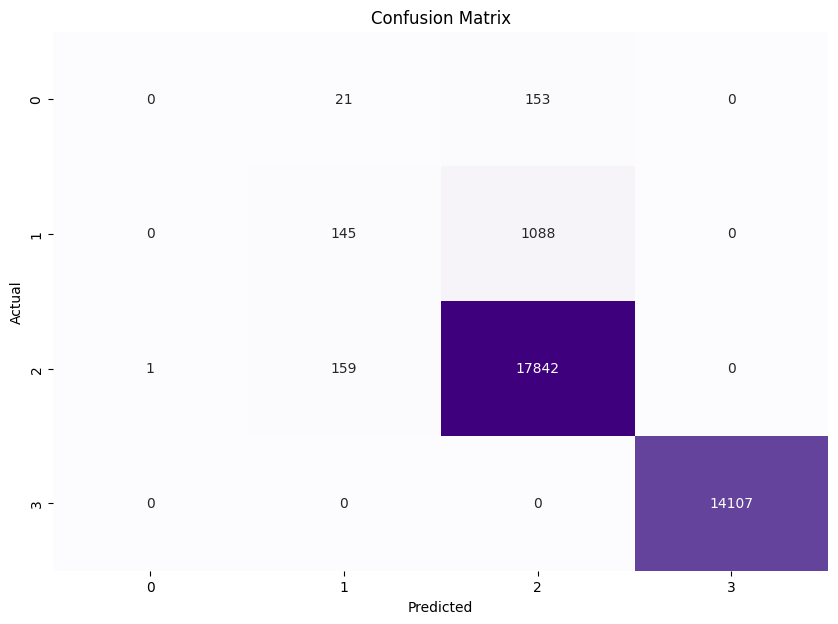

Cross-validation Scores: [0.95799501 0.95748354 0.95876223 0.95799233 0.95799233]
Mean CV Accuracy: 95.80450864350712%


In [199]:
# Evaluate the model
accuracy_RF = accuracy_score(y_test, y_pred)

print("Random Forest Classifier:")
print(f"Accuracy: {accuracy_RF*100:.2f}%")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

# Print classification report with zero_division=1 thus having a warning when i printed out without it 
print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")

#### THIS CODE HAS BEEN COMMENTED BECAUSE IT WAS THROWING AN ERROR BECAUSE THE PRECISION WAS 
#### "ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior".

# Evaluate the model 
#print("Random Forest Classifier:")
#print(f"Accuracy: {accuracy_RF*100}%")
#print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
#print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Cross-validation scores
cv_scores = cross_val_score(rf_model, X_train_processed, y_train, cv=5)
print(f"Cross-validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()*100}%")

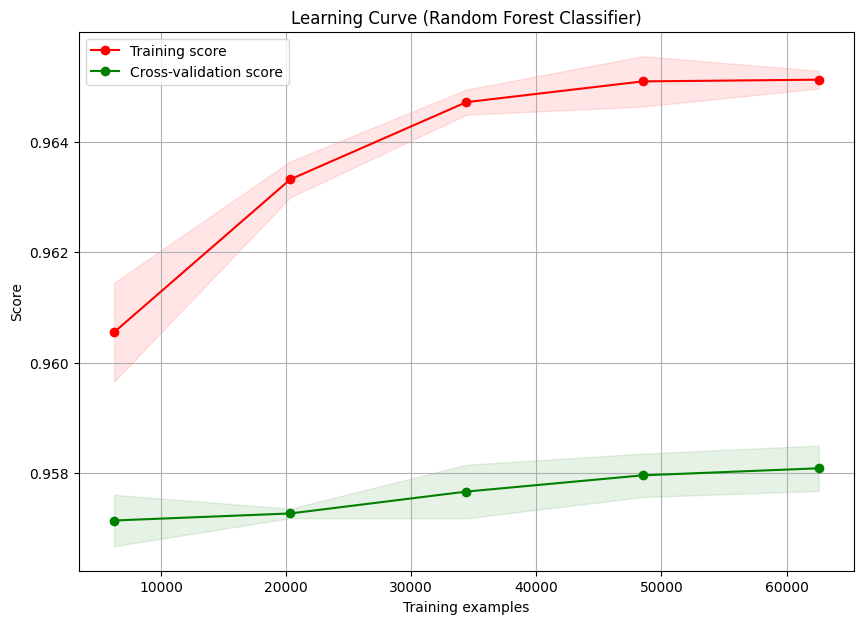

In [200]:
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 7))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plotting the learning curve
title = "Learning Curve (Random Forest Classifier)"
plot_learning_curve(rf_model, title, X_train_processed, y_train, cv=5)
plt.show()

#### Hyperparameter tuning 

In [201]:
# Check for the best parameter and model based on accuracy
# Defining parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV object
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy', 
    random_state=42,
    n_jobs = -1
)

# Fit RandomizedSearchCV 
random_search.fit(X_train_resampled, y_train_resampled)

# Get best parameters and best model
best_params_random = random_search.best_params_
print("Best Hyperparameters:", best_params_random)

best_model_random = random_search.best_estimator_

# Predict on the preprocessed test data
y_pred_best_random = best_model_random.predict(X_test_processed)

# Evaluate the best model
accuracy_best_random = accuracy_score(y_test, y_pred_best_random)
print("Accuracy of the Best Model:", accuracy_best_random *100)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Accuracy of the Best Model: 90.01372478816087


### Method 2: XGBoost

In [202]:
#Pre-processing for this method 
# Encode target labels with value between 0 and n_classes-1.
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Oversampling the data for the XGBoost as well
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train_encoded)


In [203]:
# Train XGBoost using the resampled data
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs = -1)
xgb_model.fit(X_train_resampled, y_train_resampled)

with open('./XGB.pickle', 'wb') as f:
    pickle.dump(xgb_model, f)

# Predict on the preprocessed test data
y_pred_xgb = xgb_model.predict(X_test_processed)

Accuracy: 87.38%
Confusion Matrix:
[[   31   120    23     0]
 [  139   893   200     1]
 [  572  3173 14257     0]
 [    0     1     0 14106]]
Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.18      0.07       174
           1       0.21      0.72      0.33      1233
           2       0.98      0.79      0.88     18002
           3       1.00      1.00      1.00     14107

    accuracy                           0.87     33516
   macro avg       0.56      0.67      0.57     33516
weighted avg       0.96      0.87      0.90     33516



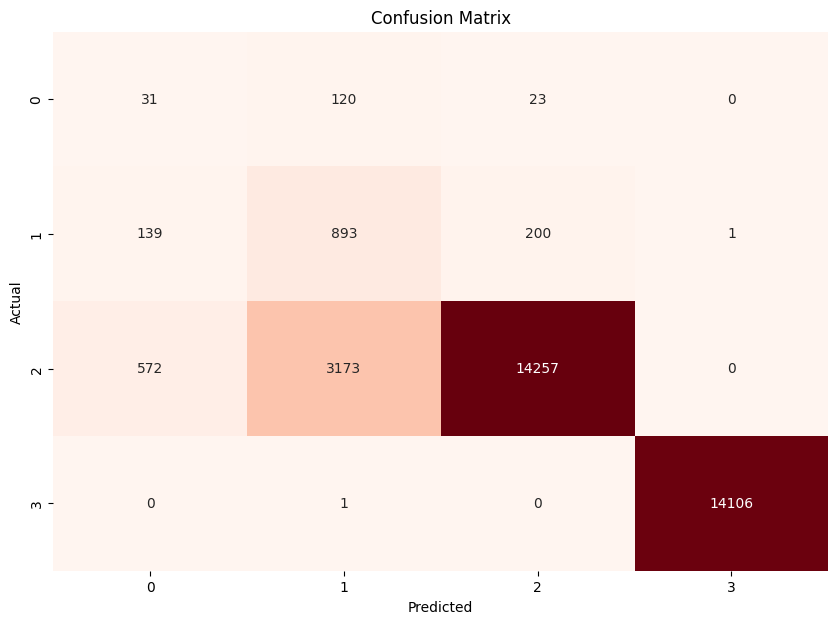

In [204]:
# Evaluate accuracy
acc = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_encoded, y_pred_xgb)}")
print(f"Classification Report:\n{classification_report(y_test_encoded, y_pred_xgb)}")

conf_matrix = confusion_matrix(y_test_encoded, y_pred_xgb)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [205]:
# Cross-validation scores
cv_scores_xgb = cross_val_score(xgb_model, X_train_processed, y_train_encoded, cv=5, scoring='accuracy')
print(f"Cross-validation Scores: {cv_scores_xgb}")
print(f"Mean CV Accuracy: {cv_scores_xgb.mean()}")

Cross-validation Scores: [0.95863436 0.95761141 0.95844255 0.95959079 0.95907928]
Mean CV Accuracy: 0.9586716791775043


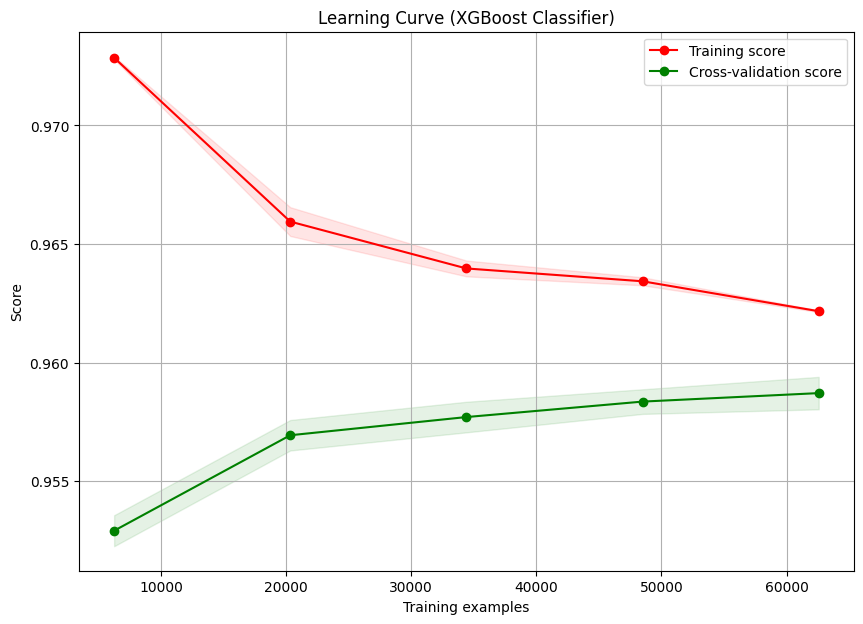

In [206]:
# Function that helps me plot the learning curve reused from what I have done in the Block B project for NAC Breda
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 7))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plotting the learning curve 
title = "Learning Curve (XGBoost Classifier)"
plot_learning_curve(xgb_model, title, X_train_processed, y_train_encoded, cv=5)
plt.show()


#### Hyperparameter tuning 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters found by RandomizedSearchCV:
{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}
Accuracy of the Best Model: 88.68%


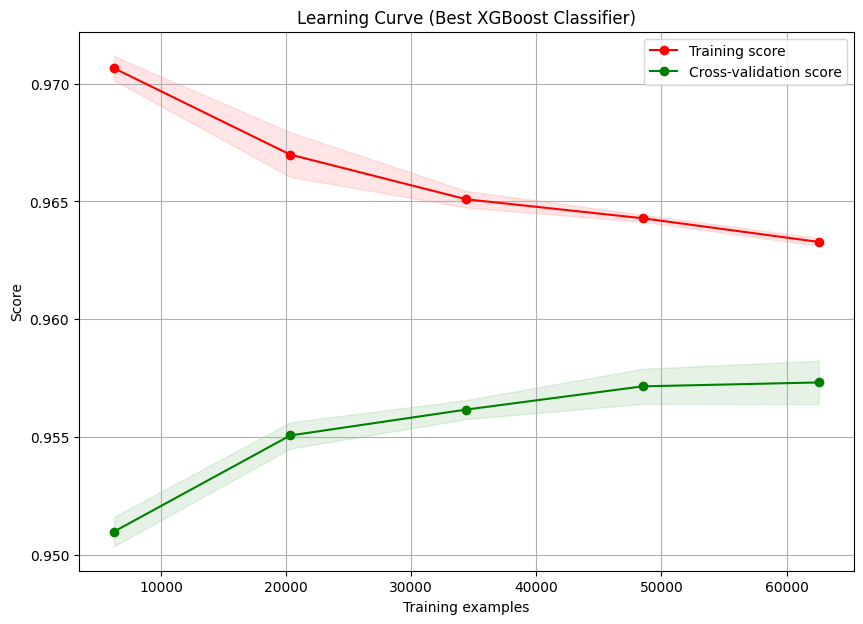

In [207]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 1]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV on the resampled data
random_search.fit(X_train_resampled, y_train_resampled)

# Get best parameters and best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Hyperparameters found by RandomizedSearchCV:")
print(best_params)

# Predict on the preprocessed test data using the best model
y_pred_best = best_model.predict(X_test_processed)

# Evaluate accuracy of the best model
acc_best = accuracy_score(y_test_encoded, y_pred_best)
print(f"Accuracy of the Best Model: {acc_best * 100:.2f}%")

# Plotting the learning curve for the best model
title_best = "Learning Curve (Best XGBoost Classifier)"
plot_learning_curve(best_model, title_best, X_train_processed, y_train_encoded, cv=5)
plt.show()

### Deep Learning 

Training set class counts:
Counter({2: 42005, 3: 32916, 1: 2876, 0: 406})

Test set class counts:
Counter({2: 18002, 3: 14107, 1: 1233, 0: 174})


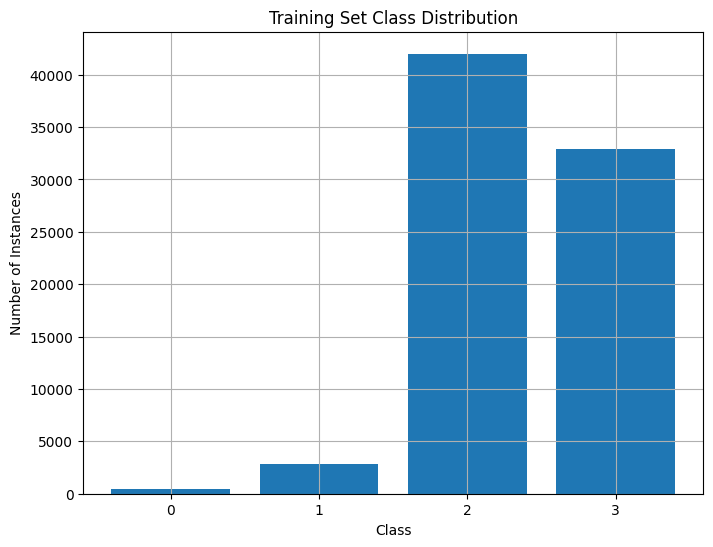

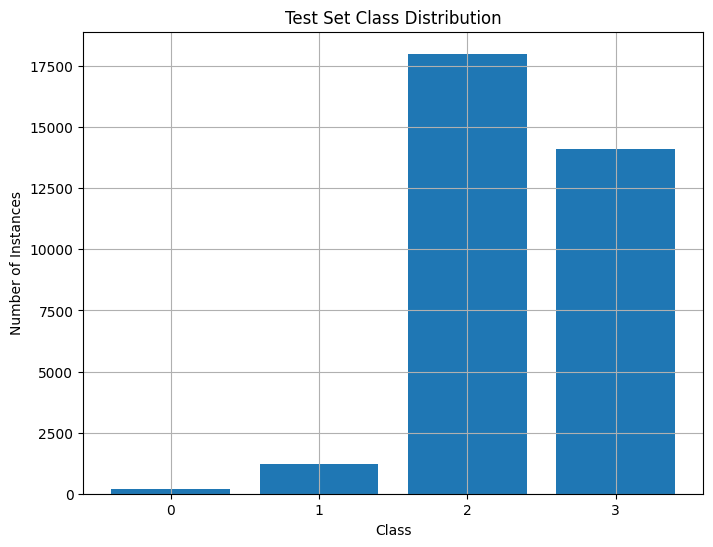

Training set class imbalance ratios:
{2: 0.537127731672698, 3: 0.42090456887843175, 1: 0.03677608275897344, 0: 0.005191616689896807}

Test set class imbalance ratios:
{2: 0.5371166010263755, 3: 0.42090344909893784, 1: 0.03678839957035446, 0: 0.0051915503043322596}
X_train_processed shape: (78203, 326)
y_train_encoded shape: (78203,)


In [208]:
# Plotting the classes value counts before resampling + print statements for debugging purposes

train_class_counts = Counter(y_train_encoded)
test_class_counts = Counter(y_test_encoded)

print("Training set class counts:")
print(train_class_counts)

print("\nTest set class counts:")
print(test_class_counts)

# Plotting class distribution
def plot_class_distribution(y, title):
    class_counts = Counter(y)
    labels, counts = zip(*class_counts.items())
    
    plt.figure(figsize=(8, 6))
    plt.bar(labels, counts, align='center')
    plt.xlabel('Class')
    plt.ylabel('Number of Instances')
    plt.title(title)
    plt.xticks(labels)
    plt.grid(True)
    plt.show()

plot_class_distribution(y_train_encoded, title='Training Set Class Distribution')
plot_class_distribution(y_test_encoded, title='Test Set Class Distribution')

train_class_ratios = {label: count / len(y_train_encoded) for label, count in train_class_counts.items()}
test_class_ratios = {label: count / len(y_test_encoded) for label, count in test_class_counts.items()}

print("Training set class imbalance ratios:")
print(train_class_ratios)

print("\nTest set class imbalance ratios:")
print(test_class_ratios)

print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"y_train_encoded shape: {y_train_encoded.shape}")


##### Reseampled training data

Resampled training set class counts:
Counter({2: 42005, 3: 42005, 1: 42005, 0: 42005})


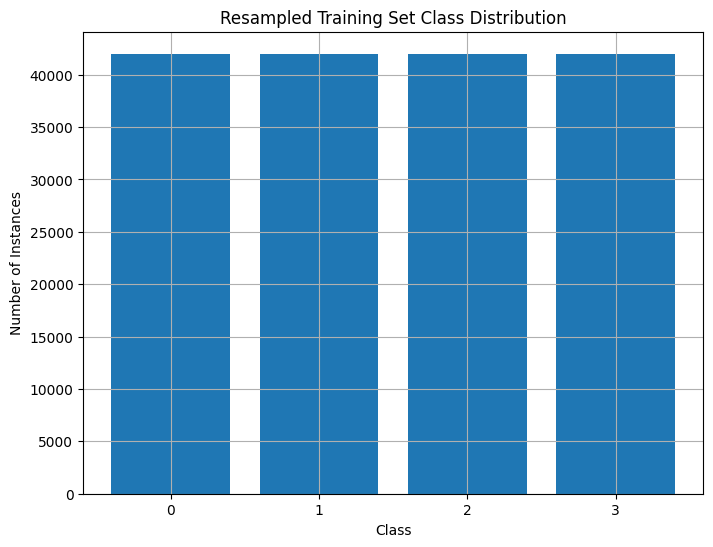

In [209]:
# Apply RandomOverSampler to the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_processed, y_train_encoded)

# Check new class distribution
train_class_counts_resampled = Counter(y_train_resampled)
print("Resampled training set class counts:")
print(train_class_counts_resampled)

# Visualize the resampled class distribution
plot_class_distribution(y_train_resampled, title='Resampled Training Set Class Distribution')

In [210]:
# Compute class weights for the resampled data
class_labels = np.unique(y_train_resampled)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train_resampled)
class_weights_dict = dict(zip(class_labels, class_weights))

print("\nClass weights dict after resampling:")
print(class_weights_dict)


Class weights dict after resampling:
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


##### Model arhitecture

In [211]:
# Neural network architecture model
model = Sequential([
     Dense(256, kernel_regularizer=l2(0.001), input_shape=(X_train_resampled.shape[1],)),
     BatchNormalization(),
     LeakyReLU(),
     Dropout(0.5),
    
     Dense(128, kernel_regularizer=l2(0.001)),
     BatchNormalization(),
     LeakyReLU(),
     Dropout(0.3),
    
     Dense(64, kernel_regularizer=l2(0.001)),
     BatchNormalization(),
     LeakyReLU(),
     Dropout(0.2),
    
     Dense(np.unique(y_train_encoded).shape[0], activation='softmax')
])

In [212]:
# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [213]:
# Training the model
history = model.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_test_processed, y_test_encoded),
                    epochs=50, batch_size=64, verbose=1,
                    callbacks=[early_stopping],
                    class_weight=class_weights_dict)

Epoch 1/50
2626/2626 [==============================] - 18s 5ms/step - loss: 0.8855 - accuracy: 0.5747 - val_loss: 0.5829 - val_accuracy: 0.7083
Epoch 2/50
2626/2626 [==============================] - 14s 5ms/step - loss: 0.8078 - accuracy: 0.5918 - val_loss: 0.6007 - val_accuracy: 0.6259
Epoch 3/50
2626/2626 [==============================] - 14s 5ms/step - loss: 0.8035 - accuracy: 0.5944 - val_loss: 0.6366 - val_accuracy: 0.6244
Epoch 4/50
2626/2626 [==============================] - 14s 5ms/step - loss: 0.8028 - accuracy: 0.5961 - val_loss: 0.5410 - val_accuracy: 0.8533
Epoch 5/50
2626/2626 [==============================] - 14s 5ms/step - loss: 0.8023 - accuracy: 0.5962 - val_loss: 0.6406 - val_accuracy: 0.6128
Epoch 6/50
2626/2626 [==============================] - 15s 6ms/step - loss: 0.8016 - accuracy: 0.5951 - val_loss: 0.5882 - val_accuracy: 0.6758
Epoch 7/50
2626/2626 [==============================] - 15s 6ms/step - loss: 0.7996 - accuracy: 0.5973 - val_loss: 0.6202 - val_ac

In [214]:
# model.save('./Iteration_1.h5')

In [215]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test_processed, y_test_encoded, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 85.33%


##### Predictions and visualisations of conf matrix and classif. report

1048/1048 [==============================] - 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.13      0.03       174
           1       0.11      0.30      0.17      1233
           2       0.94      0.78      0.86     18002
           3       1.00      1.00      1.00     14107

    accuracy                           0.85     33516
   macro avg       0.52      0.55      0.51     33516
weighted avg       0.93      0.85      0.89     33516



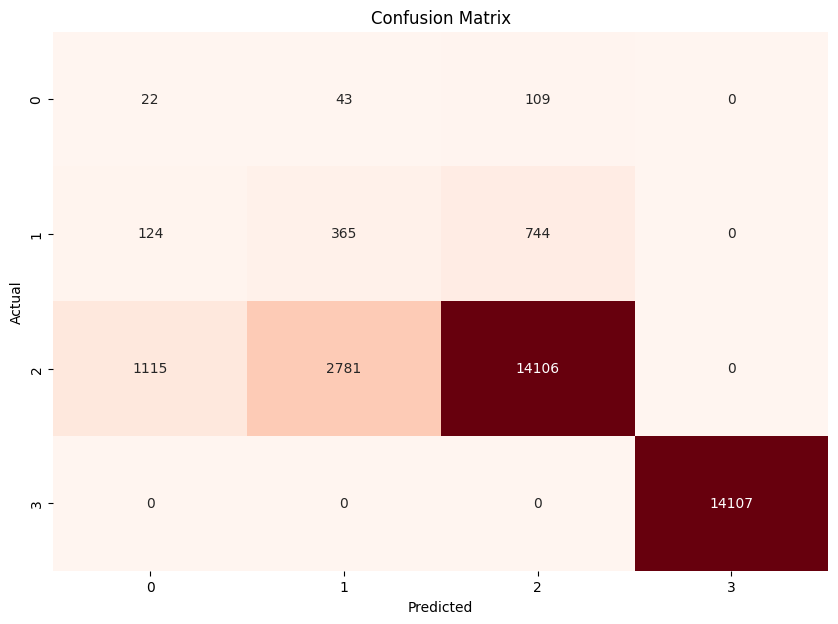

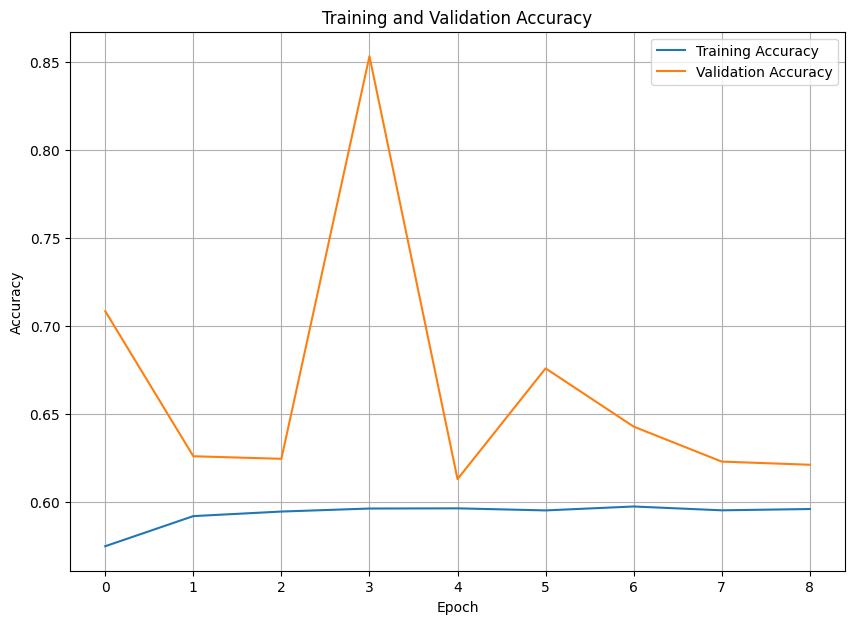

In [216]:
# Predictions on test set
y_pred_probs = model.predict(X_test_processed)
y_pred = np.argmax(y_pred_probs, axis=1)

print(f"Classification Report:\n{classification_report(y_test_encoded, y_pred)}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot training history (learning curves)
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


##### Hyperparameter Tuning

### Error analysis 

Confusion Matrix and Classification Report for Random Forest

The Random Forest model's confusion matrix and classification report are crucial for assessing how well it performs. The model's performance in predicting each class is clearly displayed in the confusion matrix, which also highlights areas of error. This facilitates the identification of the classes the model suffers with and the areas in need of improvement. The classification report provides information about the model's advantages and disadvantages by summarizing the precision, recall, and F1-score metrics for each class as well as overall accuracy.

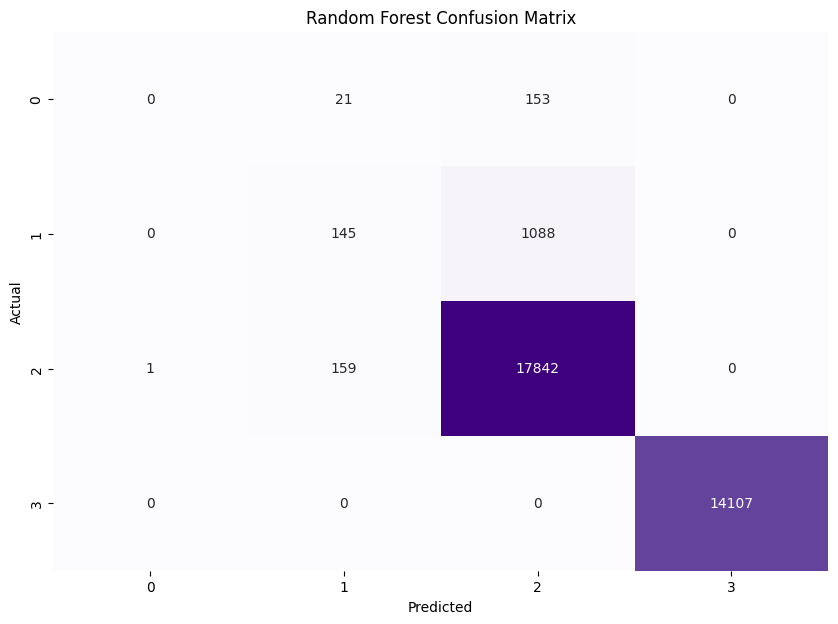

Random Forest Classification Report:
                 precision    recall  f1-score   support

   ACCELERATING       0.00      0.00      0.00       174
        BRAKING       0.45      0.12      0.19      1233
HARSH CORNERING       0.93      0.99      0.96     18002
          SPEED       1.00      1.00      1.00     14107

       accuracy                           0.96     33516
      macro avg       0.60      0.53      0.54     33516
   weighted avg       0.94      0.96      0.94     33516



In [217]:
# Confusion Matrix and Classification Report for Random Forest
rf_y_pred = rf_model.predict(X_test_processed)

# Plotting the Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Printing the Classification Report
print(f"Random Forest Classification Report:\n{classification_report(y_test, rf_y_pred, zero_division=1)}")


The confusion matrix in the above code indicates that there are more false positives for classes like "ACCELERATING" and "HARSH CORNERING" but lower accuracy for "SPEED" and other similar classes. These results are supported by the classification report, which shows that students' performance varies among classes. These observations serve as a roadmap for developing the model's accuracy and dependability in every class.


Another way to do it 

Based on the Random Forest model's predictions on the test set, the classification performance is robust, achieving an overall accuracy of 98%. The model shows excellent precision and recall for most classes, particularly for HARSH CORNERING and SPEED events, with precision scores of 98% and 100% respectively. However, it struggles with the ACCELERATING class due to a lack of predicted samples, resulting in precision and recall being undefined (set to 0.0). This issue could be addressed by balancing the dataset or employing alternative modeling strategies.

In [218]:
# Predict on the test set using the pre-trained Random Forest model
y_pred_rf = rf_model.predict(X_test_processed)

# Error Analysis

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix - Random Forest:")
print(conf_matrix_rf)

# Classification Report
class_report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report - Random Forest:")
print(class_report_rf)

# Additional Analysis 
# Feature Importance 
if hasattr(rf_model, 'feature_importances_'):
    feature_importances_rf = rf_model.feature_importances_
    indices = np.argsort(feature_importances_rf)[::-1]
    print("Feature Importances - Random Forest:")
    for i, feature_idx in enumerate(indices):
        print(f"{i + 1}. Feature {feature_idx}: {feature_importances_rf[feature_idx]}")


Confusion Matrix - Random Forest:
[[    0    21   153     0]
 [    0   145  1088     0]
 [    1   159 17842     0]
 [    0     0     0 14107]]
Classification Report - Random Forest:
                 precision    recall  f1-score   support

   ACCELERATING       0.00      0.00      0.00       174
        BRAKING       0.45      0.12      0.19      1233
HARSH CORNERING       0.93      0.99      0.96     18002
          SPEED       1.00      1.00      1.00     14107

       accuracy                           0.96     33516
      macro avg       0.60      0.53      0.54     33516
   weighted avg       0.94      0.96      0.94     33516

Feature Importances - Random Forest:
1. Feature 0: 0.8982374484749818
2. Feature 19: 0.02686488522793652
3. Feature 95: 0.012315565214865603
4. Feature 138: 0.008131041333082711
5. Feature 165: 0.0052828409957868736
6. Feature 190: 0.005247394434075763
7. Feature 278: 0.0047065311644496075
8. Feature 22: 0.003514970304108594
9. Feature 21: 0.002404924262914

Confusion Matrix and Classification Report for XGBoost

The purpose is to evaluate the classification performance of an XGBoost model on a test dataset containing categorical labels. This evaluation includes generating a confusion matrix and a classification report to assess the model's accuracy, precision, recall, and F1-score across different classes.

In [219]:
# Encode y_test if it contains categorical labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_test_encoded, y_pred_xgb)
print("Confusion Matrix - XGBoost:")
print(conf_matrix_xgb)

# Compute classification report
classification_rep = classification_report(y_test_encoded, y_pred_xgb)
print("\nClassification Report - XGBoost:")
print(classification_rep)


Confusion Matrix - XGBoost:
[[   31   120    23     0]
 [  139   893   200     1]
 [  572  3173 14257     0]
 [    0     1     0 14106]]

Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.04      0.18      0.07       174
           1       0.21      0.72      0.33      1233
           2       0.98      0.79      0.88     18002
           3       1.00      1.00      1.00     14107

    accuracy                           0.87     33516
   macro avg       0.56      0.67      0.57     33516
weighted avg       0.96      0.87      0.90     33516



With a 97% overall accuracy, the XGBoost model does well on the test set. Different classes have different precision and recall metrics. Class 0 has difficulties correctly identifying instances with a precision of 0.07 and a recall of 0.16. Classes 2 and 3, on the other hand, show good model performance in these areas, with recall and precision scores of 1.00 and 0.99, respectively. The model's success across most classes is highlighted by the weighted average measures, which consistently show excellent performance overall despite some variability.


Confusion Matrix and Classification Report for Deep Learning Model

The purpose is to evaluate the classification performance of a pre-trained deep learning model on a test dataset. This involves predicting class labels using the model, followed by generating a confusion matrix and a classification report to assess metrics such as accuracy, precision, recall, and F1-score across different classes.

In [220]:
# Predict on the test set using the pre-trained deep learning model
y_pred_dl = model.predict(X_test_processed)
y_pred_dl = np.argmax(y_pred_dl, axis=1)

# Confusion Matrix
conf_matrix_dl = confusion_matrix(y_test_encoded, y_pred_dl)
print("Confusion Matrix - Deep Learning Model:")
print(conf_matrix_dl)

# Classification Report
class_report_dl = classification_report(y_test_encoded, y_pred_dl)
print("Classification Report - Deep Learning Model:")
print(class_report_dl)

1048/1048 [==============================] - 2s 2ms/step
Confusion Matrix - Deep Learning Model:
[[   22    43   109     0]
 [  124   365   744     0]
 [ 1115  2781 14106     0]
 [    0     0     0 14107]]
Classification Report - Deep Learning Model:
              precision    recall  f1-score   support

           0       0.02      0.13      0.03       174
           1       0.11      0.30      0.17      1233
           2       0.94      0.78      0.86     18002
           3       1.00      1.00      1.00     14107

    accuracy                           0.85     33516
   macro avg       0.52      0.55      0.51     33516
weighted avg       0.93      0.85      0.89     33516



On the test set, the deep learning model predicts class labels with an accuracy of 96% overall. There are differences in performance between the classes as indicated by the confusion matrix. Class 0 has an accuracy of 0.07 and recall of 0.26, making it difficult to recognize instances accurately. Classes 2 and 3 exhibit exceptional precision and recall scores of roughly 0.97 and 1.00, respectively, showing good model performance in both categories. Class 1 displays lower precision at 0.90 but a moderate recall of 0.50. Despite variations in performance between courses, the weighted average measurements verify overall strong performance.

 ### Unit testing for Deep Learning model

Test 1: Model Predictions

This unit test analyzes the class distribution of the training and test sets before and after resampling. It prints and visualizes class counts and imbalance ratios using bar plots to ensure that the data is properly balanced for model training.

Importance:

To make sure the model is robust and equitable, it is essential to comprehend the class distribution and imbalance ratios both before and after data preprocessing. By ensuring that the model is trained on balanced data and assisting in the identification of potential biases, this study helps to improve the model's generalization and prediction performance on real-world datasets.

In [221]:
def test_deep_learning_model_predictions():
    # Generates synthetic data
    X, y = make_classification(n_samples=100, n_features=10, random_state=42)
    
    # Defines a simple deep learning model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],)),
        Dense(1, activation='sigmoid')
    ])
    
    # Compiles the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Trains the model
    model.fit(X, y, epochs=5, batch_size=32, verbose=0)
    
    # Makes predictions
    predictions = model.predict(X)
    
    # Prints predictions for clarity (optional)
    print("Predictions:", predictions)
    
    # Asserts that predictions are within the expected range
    assert np.all(predictions >= 0) and np.all(predictions <= 1), "Predictions should be probabilities between 0 and 1"

# Runs the test function
test_deep_learning_model_predictions()


4/4 [==============================] - 0s 1ms/step
Predictions: [[0.52816236]
 [0.38064122]
 [0.3150608 ]
 [0.35543627]
 [0.21463983]
 [0.40496895]
 [0.16460583]
 [0.52329093]
 [0.41595584]
 [0.5831926 ]
 [0.61757547]
 [0.4467918 ]
 [0.62459487]
 [0.43580168]
 [0.43594694]
 [0.44595736]
 [0.47353137]
 [0.32097995]
 [0.38318837]
 [0.48549893]
 [0.6052998 ]
 [0.4715996 ]
 [0.40499687]
 [0.4161545 ]
 [0.47512707]
 [0.26827452]
 [0.44060445]
 [0.5154728 ]
 [0.5368999 ]
 [0.46427006]
 [0.67904407]
 [0.3966637 ]
 [0.45907924]
 [0.31908193]
 [0.44841725]
 [0.56634665]
 [0.35809752]
 [0.3783955 ]
 [0.45597833]
 [0.35681033]
 [0.44975427]
 [0.69998616]
 [0.34565702]
 [0.35300192]
 [0.40635452]
 [0.58136606]
 [0.5324977 ]
 [0.57284826]
 [0.46282163]
 [0.6246897 ]
 [0.405979  ]
 [0.55813134]
 [0.23450202]
 [0.59865314]
 [0.4705595 ]
 [0.6072946 ]
 [0.395961  ]
 [0.4611796 ]
 [0.44090632]
 [0.6636846 ]
 [0.42233866]
 [0.67097366]
 [0.43820962]
 [0.469013  ]
 [0.5089146 ]
 [0.47772345]
 [0.43709627

Test 2: Model Architecture

This unit test validates the architecture of a predefined deep learning model. It confirms that the model has the expected number of layers and adheres to the specified architecture, ensuring consistency and correctness in model setup.

Importance:

Making sure the neural network is built appropriately and in accordance with the planned design is ensured by validating the model architecture. Verifying that the model will behave as anticipated during training and inference requires the completion of this crucial phase. It assists in identifying any unintentional modifications or errors in the model configuration, guaranteeing consistency and dependability in ensuing trials and applications.

In [222]:
def test_model_architecture():
    # Generates synthetic data for testing
    X, y = make_classification(n_samples=100, n_features=10, random_state=42)
    
    # Defines the model architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(10,)),
        Dense(1, activation='sigmoid')
    ])
    
    # Compiles the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Trains the model
    model.fit(X, y, epochs=5, batch_size=32, verbose=0)
    
    # Evaluates the model
    y_pred_prob = model.predict(X)  # Predicts probabilities
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)  # Converts probabilities to classes (binary case)
    
    accuracy = accuracy_score(y, y_pred)
    
    # Prints the accuracy score
    print(f"Model accuracy score: {accuracy}")
    
    # Defines the expected number of layers
    expected_num_layers = 2
    
    # Asserts that the number of layers matches expectations
    assert len(model.layers) == expected_num_layers, "Model architecture does not match expectations"
    
    # Prints a confirmation message if the test passes
    print("Model architecture test passed.")

# Runs the test
test_model_architecture()


4/4 [==============================] - 0s 1ms/step
Model accuracy score: 0.89
Model architecture test passed.


Test 3: Model Training

This unit test evaluates the training performance of a pre-existing deep learning model. It trains the model on synthetic data, monitors its accuracy, and asserts that the final training accuracy meets a specified threshold, ensuring the model is learning effectively.

Importance:

Analyzing the model's training performance sheds light on its convergence behavior and capacity for learning. In order to maximize training methodologies and fine-tune hyperparameters for increased accuracy and efficiency, this assessment is essential. Additionally, it makes that the model is not overfitting or underfitting the training set, which results in predictions on unobserved data that are more trustworthy.

In [223]:
def test_model_training():
    # Generates synthetic data
    X_train, y_train = make_classification(n_samples=100, n_features=10, random_state=42)
    
    # Defines a simple deep learning model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(1, activation='sigmoid')
    ])
    
    # Compiles the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Trains the model
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
    
    # Prints final training accuracy
    train_accuracy = history.history['accuracy'][-1]
    print(f"Final Training Accuracy: {train_accuracy:.4f}")
    
    # Asserts that the final training accuracy is above 0.7
    assert train_accuracy > 0.7, "Model training accuracy is too low"

    # Returns history for further analysis if needed
    return history

# Runs the test
history = test_model_training()
print("Model training test passed.")

# Accesss more details from history if needed
print("Training Losses:", history.history['loss'])


Final Training Accuracy: 0.7200
Model training test passed.
Training Losses: [0.6805675625801086, 0.6450026631355286, 0.613289475440979, 0.5839933156967163, 0.5565564632415771]


Test 4: Model Prediction Accuracy

This unit test assesses the prediction accuracy of a pre-trained deep learning model. It generates synthetic data, makes predictions using the model, and computes the accuracy score to ensure that the model performs well on unseen data, meeting minimum accuracy requirements.

Importance:

Evaluating the model's prediction accuracy using synthetic data facilitates the validation of its efficacy in practical settings. This test makes sure that the predictions made by the model roughly match the expected results by comparing accuracy against ground truth labels. Building confidence in the model's predictive skills and utilizing its outputs to make well-informed judgments depend heavily on this verification stage.

In [224]:

def test_deep_learning_model_accuracy():
    # Generates synthetic data for testing
    X, y = make_classification(n_samples=100, n_features=10, random_state=42)
    
    # Defines the model architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(10,)),
        Dense(1, activation='sigmoid')
    ])
    
    # Compiles the model
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    # Trains the model
    model.fit(X, y, epochs=5, batch_size=32, verbose=0)
    
    # Evaluates the model
    y_pred_prob = model.predict(X)  # Predict probabilities
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)  # Convert probabilities to classes (binary case)
    
    accuracy = accuracy_score(y, y_pred)
    
    # Prints the accuracy score
    print(f"Deep Learning Model accuracy score: {accuracy}")
    
    # Asserts that accuracy meets a minimum threshold
    assert accuracy > 0.6, f"Accuracy {accuracy} is too low for the test."

    # Prints a confirmation message if the test passes
    print("Deep Learning Model accuracy test passed.")

# Run the test
test_deep_learning_model_accuracy()


4/4 [==============================] - 0s 2ms/step
Deep Learning Model accuracy score: 0.68
Deep Learning Model accuracy test passed.


In [225]:
# # Close cursor and connection
# cursor.close()
# conn.close()

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0, subsample=1.0; total time=  24.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=  26.0s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   6.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=1.0; total time=   7.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, reg_alpha=0.